# SANA on MNIST with Rectified Flow + Linear Attention


This notebook translates the main contributions of **SANA: Efficient High-Resolution Image Synthesis with Linear Diffusion Transformers** to a compact MNIST setting. The original model targets **4K** resolution with a **~0.6B‑parameter** linear‑DiT backbone, a **decoder‑only LLM text encoder (Gemma‑2B)**, and a **32×** compression autoencoder. We keep the algorithmic structure—**rectified‑flow training**, **linear self/cross‑attention**, **AdaLN‑style conditioning**, and **flow‑based DPM‑Solver sampling**—while scaling the network down so it can be trained quickly on MNIST latents.

In [1]:
import os
import math
import json
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from typing import Optional, Tuple


In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Using device: cuda




## Rectified Flow Scheduler

**Section 3.2 (Flow‑based Training / Inference).** SANA replaces the standard DDPM noise‑prediction objective with **rectified flow** (velocity prediction). The forward path linearly interpolates between clean data $x_0$ and Gaussian noise $x_1 = \varepsilon$:

$$
x_t = (1 - t),x_0 + t,x_1, \quad t \in [0, 1].
$$

The **training target** is the velocity field (time derivative of $x_t$):

$$
v_t
= \frac{\partial x_t}{\partial t}
= x_1 - x_0.
$$

So the **loss** becomes

$$
\mathcal{L}_{\text{flow}}
= \mathbb{E}_{t,\,\mathbf{x}_0,\,\varepsilon}
\Big[\,\big\|
\mathbf{v}_\theta(\mathbf{x}_t, t, c) - (\varepsilon - \mathbf{x}_0)
\big\|_2^2\,\Big].
$$

### What the scheduler class should provide

* **Data→noise interpolation**: given $(x_0, \varepsilon)$ and $t$, compute $x_t$ and the target $(\varepsilon - x_0)$.
* **Continuous times**: a `set_timesteps(num_steps, ...)` producing $t\in[0,1]$ for inference.
* **Flow‑DPM‑Solver compatibility**: expose model outputs as **velocity** $v_\theta$ and time grid in $[0,1]$ so a flow‑adapted **DPM‑Solver** can integrate the ODE efficiently (typically ~14–20 steps as in the paper).


In [3]:

class RectifiedFlowScheduler:
    """Rectified flow sampling"""
    def __init__(self, num_train_timesteps: int = 1000):
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = None
        self.dt = None

    @staticmethod
    def to_unit_interval(t: torch.Tensor, total_steps: int) -> torch.Tensor:
        return t.float() / total_steps

    def add_noise(self, x0: torch.Tensor, noise: torch.Tensor, timesteps: torch.Tensor) -> torch.Tensor:
        t = self.to_unit_interval(timesteps, self.num_train_timesteps)  # [B]
        while len(t.shape) < len(x0.shape):
            t = t.unsqueeze(-1)
        xt = (1.0 - t) * x0 + t * noise
        return xt

    def velocity_target(self, x0: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        return noise - x0

    def sample_timesteps(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.randint(0, self.num_train_timesteps, (batch_size,), device=device)

    def set_timesteps(self, num_steps: int, device: torch.device):
        self.timesteps = torch.linspace(1.0, 0.0, num_steps + 1, device=device)
        self.dt = -1.0 / num_steps


## Linear Attention Modules

**Paper reference ← Section 2.2 (Efficient Linear DiT).** SANA replaces **all** vanilla (quadratic) attention with **linear attention** to achieve $\mathcal{O}(N)$ memory/compute at high resolution. The paper cites *ReLU linear attention* (Katharopoulos et al., 2020) and illustrates the shared‑term factorization (their Eq. (1)):

$$
\operatorname{Attn}(Q,K,V)
;=; \frac{\Phi(Q)[\Phi(K)^{\top}V]}{\Phi(Q)[\Phi(K)^{\top}\mathbf{1}]}
$$

where $\Phi(\cdot)$ is a **positive** feature map enabling kernel factorization, and $\mathbf{1}$ is a vector of ones. This avoids materializing the $N\times N$ attention matrix.

> **Kernel choice.** The SANA paper text refers to **ReLU linear attention**; common linear‑attention implementations use either $\Phi(x)=\mathrm{ReLU}(x)$ or $\Phi(x)=\mathrm{ELU}(x)+1$ (the latter from Katharopoulos et al.). If we use $\mathrm{ELU}(x)+1$ in our MNIST port, document it as an **implementation choice** consistent with the linear‑attention formulation, not a paper constraint.

**Cross‑attention:** Apply the same linearization to image–text attention to keep $\mathcal{O}(N)$ scaling.

**Why it matters (even for MNIST):** Although MNIST is modest, keeping the linear modules preserves the **algorithmic invariants** of SANA and simplifies scaling up to higher resolutions later.


In [4]:

class LinearSelfAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def _reshape(self, tensor):
        B, N, C = tensor.shape
        tensor = tensor.view(B, N, self.num_heads, self.head_dim)
        tensor = tensor.permute(0, 2, 1, 3)
        return tensor

    @staticmethod
    def _kernel(x):
        return F.elu(x) + 1

    def forward(self, x):
        qkv = self.qkv(x)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        q = self._reshape(q)
        k = self._reshape(k)
        v = self._reshape(v)

        q_phi = self._kernel(q)
        k_phi = self._kernel(k)

        context = torch.einsum('b h n d, b h n e -> b h d e', k_phi, v)
        denom = torch.einsum('b h n d, b h n d -> b h n', q_phi, k_phi).unsqueeze(-1)
        out = torch.einsum('b h n d, b h d e -> b h n e', q_phi, context)
        out = out / (denom + 1e-6)

        out = out.permute(0, 2, 1, 3).reshape(x.shape)
        return self.proj(out)


class LinearCrossAttention(nn.Module):
    def __init__(self, dim: int, context_dim: int, num_heads: int):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(context_dim, dim * 2)
        self.proj = nn.Linear(dim, dim)

    def _reshape(self, tensor):
        B, N, C = tensor.shape
        tensor = tensor.view(B, N, self.num_heads, self.head_dim)
        tensor = tensor.permute(0, 2, 1, 3)
        return tensor

    @staticmethod
    def _kernel(x):
        return F.elu(x) + 1

    def forward(self, x, context):
        q = self._reshape(self.q(x))
        kv = self.kv(context)
        k, v = torch.chunk(kv, 2, dim=-1)
        k = self._reshape(k)
        v = self._reshape(v)

        q_phi = self._kernel(q)
        k_phi = self._kernel(k)

        context_mat = torch.einsum('b h m d, b h m e -> b h d e', k_phi, v)
        denom = torch.einsum('b h n d, b h m d -> b h n', q_phi, k_phi).unsqueeze(-1)
        out = torch.einsum('b h n d, b h d e -> b h n e', q_phi, context_mat)
        out = out / (denom + 1e-6)

        out = out.permute(0, 2, 1, 3).reshape(x.shape)
        return self.proj(out)


## SANA Block & Model (paper‑accurate)

**Scope.** What follows mirrors the *paper* design of SANA’s Linear‑DiT; any extra gates or module splits you might see in third‑party repos are implementation choices.

1. **AdaLN‑style conditioning.** SANA keeps DiT’s macro layout and conditions blocks with adaptive normalization around self‑attention (SA), cross‑attention (CA), and the FFN. The paper does **not** introduce a special “nine‑group” AdaLN or per‑stage gates. It *does* normalize text features with **RMSNorm** and applies a small learnable **scale (≈0.01)** before feeding them to CA to stabilize training, then uses standard residual connections.

2. **Linear attention everywhere.** SANA replaces softmax attention with **linear attention** (ReLU kernel) for efficiency at long sequence lengths. In practice this is applied to both SA (image tokens) and CA (image↔text), matching the “replace all vanilla attention with linear attention” claim.

3. **Mix‑FFN (with GLU).** The MLP is replaced by a **Mix‑FFN**: inverted residual → **3×3 depth‑wise conv** → **GLU** → projection. This both speeds convergence and enables **NoPE** (no positional embeddings) since the 3×3 conv injects local/spatial bias.

4. **NoPE (no positional embeddings).** Unlike prior DiT variants (absolute PE / RoPE), SANA reports no quality loss without positional encodings, attributed to Mix‑FFN’s local conv.

5. **Prediction head.** The transformer predicts **velocity** $v_	heta(x_t, t, 	au(y))$ (rectified‑flow target), not noise.

### Minimal MNIST porting notes

* Keep the **linear SA/CA** and **Mix‑FFN** structure; scale width/heads down for MNIST.
* If you add extra adaLN gates or zero‑init tricks for convenience, mark them clearly as **implementation deviations** from the paper.
* Retain **RMSNorm+small‑scale** on text embeddings if you use a decoder‑only text encoder; otherwise a plain projection is fine for toy demos.


In [5]:

class Timesteps(nn.Module):
    def __init__(self, hidden_size: int, freq_size: int = 256):
        super().__init__()
        self.freq_size = freq_size
        self.mlp = nn.Sequential(
            nn.Linear(freq_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(-math.log(max_period) * torch.arange(0, half, device=t.device) / half)
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if dim % 2:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
        return emb

    def forward(self, t):
        emb = self.timestep_embedding(t, self.freq_size)
        return self.mlp(emb)


class SANABlock(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int, mlp_ratio: float = 4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.norm3 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)

        self.self_attn = LinearSelfAttention(hidden_size, num_heads)
        self.cross_attn = LinearCrossAttention(hidden_size, hidden_size, num_heads)

        mlp_hidden = int(hidden_size * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden),
            nn.GELU(),
            nn.Linear(mlp_hidden, hidden_size)
        )

        self.modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size * 9)
        )

    def forward(self, x, c, text_emb):
        shift_sa, scale_sa, gate_sa, shift_ca, scale_ca, gate_ca, shift_mlp, scale_mlp, gate_final = self.modulation(c).chunk(9, dim=1)

        x1 = self.norm1(x) * (1 + scale_sa.unsqueeze(1)) + shift_sa.unsqueeze(1)
        x = x + gate_sa.unsqueeze(1) * self.self_attn(x1)

        x2 = self.norm2(x) * (1 + scale_ca.unsqueeze(1)) + shift_ca.unsqueeze(1)
        x = x + gate_ca.unsqueeze(1) * self.cross_attn(x2, text_emb)

        x3 = self.norm3(x) * (1 + scale_mlp.unsqueeze(1)) + shift_mlp.unsqueeze(1)
        x = gate_final.unsqueeze(1) * (x + self.mlp(x3))
        return x


class SANA(nn.Module):
    def __init__(self, input_size=32, patch_size=2, in_channels=4, hidden_size=512, depth=12, num_heads=8, text_dim=512):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = in_channels

        num_patches = (input_size // patch_size) ** 2
        self.patch_embed = nn.Linear(patch_size * patch_size * in_channels, hidden_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size))

        self.time_embed = Timesteps(hidden_size)
        self.text_proj = nn.Linear(text_dim, hidden_size)

        self.blocks = nn.ModuleList([
            SANABlock(hidden_size, num_heads)
            for _ in range(depth)
        ])

        self.final_layer = nn.Sequential(
            nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6),
            nn.Linear(patch_size * patch_size * self.out_channels, patch_size * patch_size * self.out_channels)
        )

        self.output = nn.Linear(hidden_size, patch_size * patch_size * self.out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        def _init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        self.apply(_init)
        nn.init.normal_(self.pos_embed, std=0.02)

    def patchify(self, x):
        B, C, H, W = x.shape
        p = self.patch_size
        h, w = H // p, W // p
        x = x.view(B, C, h, p, w, p)
        x = x.permute(0, 2, 4, 3, 5, 1).reshape(B, h * w, p * p * C)
        return x

    def unpatchify(self, x):
        B, N, D = x.shape
        p = self.patch_size
        h = w = int(math.sqrt(N))
        x = x.view(B, h, w, p, p, self.out_channels)
        x = x.permute(0, 5, 1, 3, 2, 4).reshape(B, self.out_channels, h * p, w * p)
        return x

    def forward(self, x, timesteps, text_emb):
        patches = self.patchify(x)
        hidden = self.patch_embed(patches) + self.pos_embed

        t_emb = self.time_embed(timesteps)
        text = self.text_proj(text_emb)

        for block in self.blocks:
            hidden = block(hidden, t_emb, text)

        out = self.output(hidden)
        out = self.unpatchify(out)
        return out



## Lightweight DC‑AE (32× compression)

**Paper reference ← Section 2.1 (Deep Compression Autoencoder).** SANA introduces **DC‑AE** that compresses RGB images by **32×** (AE‑F32) with **32 latent channels** (C32), drastically reducing token count before the DiT. This is the component used in the full 4K pipeline.

**Our MNIST approximation.** For the compact notebook, we replace DC‑AE with a **lightweight convolutional autoencoder** trained directly on MNIST:

* **Encode** grayscale digits to a small latent tensor $z_0$ (keeping the overall 32× spatial compression target when feasible).
* **Model** rectified‑flow trajectories in latent space with the Linear‑DiT.
* **Decode** generated latents back to pixels via the decoder.

This preserves the **end‑to‑end workflow** (encode → latent‑space generation → decode) while keeping parameters and compute minimal. Note that DC‑AE in the paper includes additional techniques (e.g., residual autoencoding, decoupled high‑resolution adaptation) that we omit here for simplicity; treat this as an **implementation deviation** for the MNIST demo, not a paper claim.


In [6]:

class DCAE(nn.Module):
    def __init__(self, latent_channels=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.SiLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(128, latent_channels, 4, stride=2, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, 4, stride=2, padding=1), nn.SiLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.SiLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.SiLU(),
            nn.Conv2d(32, 1, 3, padding=1), nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return z, recon


## Dataset preparation and train DC-AE

We normalize MNIST to `[-1,1]`, train the DC-AE for 5 epochs using MSE reconstruction loss, and visualize reconstructions to ensure the latent representation retains digit structure. In the paper the DC-AE is pretrained on the full LAION dataset with multi-step perceptual losses; here we keep the reconstruction objective simple to focus on the flow-matching dynamics.


Training DC-AE (5 epochs)...


AE Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

AE Epoch 1 | Recon Loss: 0.0514


AE Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4ccf72440>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4ccf72440>
Traceback (most recent call last):
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/en

AE Epoch 2 | Recon Loss: 0.0023


AE Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in:   File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4ccf72440>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb4ccf72440>if w.is_alive():
Traceback (most recent call last):

  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/torch/ut

AE Epoch 3 | Recon Loss: 0.0013


AE Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

AE Epoch 4 | Recon Loss: 0.0008


AE Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

AE Epoch 5 | Recon Loss: 0.0006


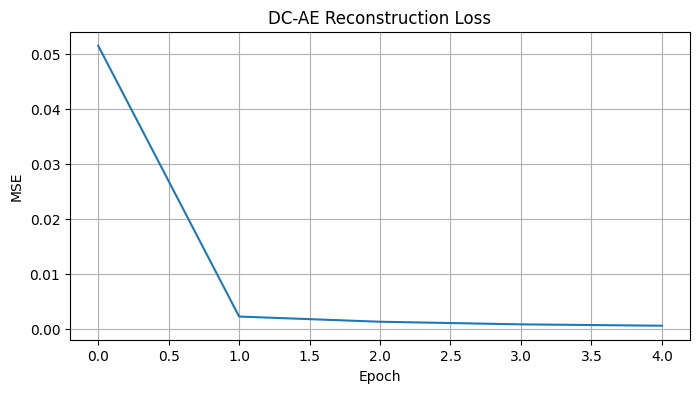

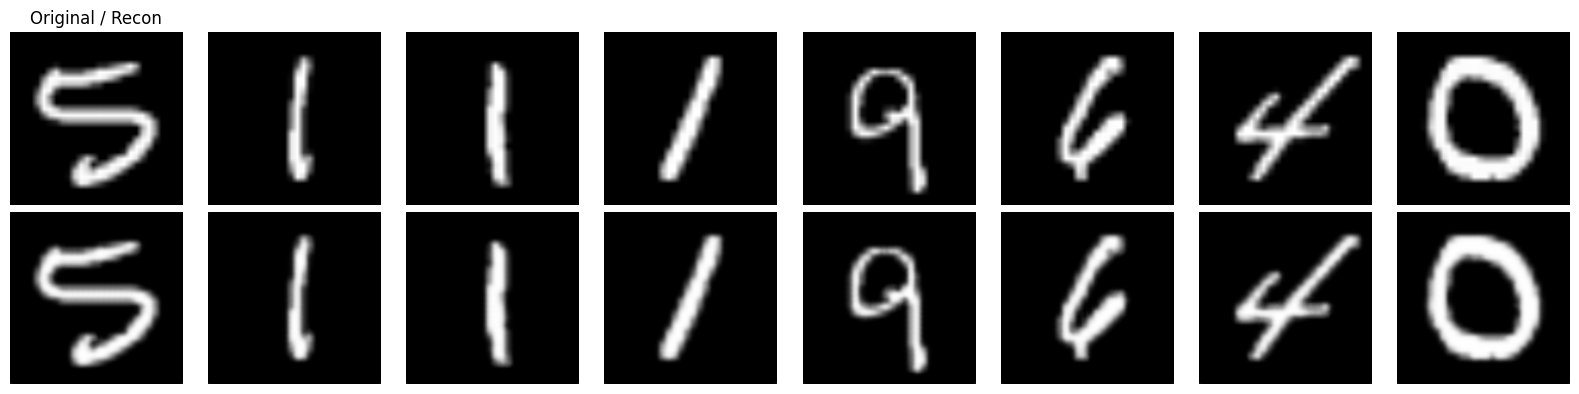

In [8]:

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader_ae = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

dcae = DCAE(latent_channels=4).to(device)
optimizer_ae = torch.optim.AdamW(dcae.parameters(), lr=2e-4)

recon_losses = []
dcae.train()
print('Training DC-AE (5 epochs)...')
for epoch in range(5):
    total = 0.0
    for images, _ in tqdm(train_loader_ae, desc=f'AE Epoch {epoch+1}/5'):
        images = images.to(device)
        z, recon = dcae(images)
        loss = F.mse_loss(recon, images)

        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

        total += loss.item()
    avg = total / len(train_loader_ae)
    recon_losses.append(avg)
    print(f'AE Epoch {epoch+1} | Recon Loss: {avg:.4f}')

plt.figure(figsize=(8,4))
plt.plot(recon_losses)
plt.title('DC-AE Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

with torch.no_grad():
    sample, _ = next(iter(train_loader_ae))
    sample = sample[:8].to(device)
    _, recon = dcae(sample)
    stacked = torch.cat([sample, recon], dim=0)
    stacked = (stacked * 0.5 + 0.5).clamp(0,1)

fig, axes = plt.subplots(2, 8, figsize=(16,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(stacked[i,0].cpu(), cmap='gray')
    ax.axis('off')
axes[0,0].set_title('Original / Recon')
plt.tight_layout()
plt.show()


## Latent caching

Following the SANA data pipeline, we precompute latent codes `z_0 = E(x)` and text embeddings `τ(y)` for every sample. The paper caches features on-the-fly with TPU memory, while we store tensors in RAM. Text prompts are encoded with T5-small instead of Gemma-2B; this yields 512-dimensional embeddings but preserves the multi-modal conditioning path.


In [9]:

from transformers import T5Tokenizer, T5EncoderModel

print('Preparing text encoder...')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_encoder = T5EncoderModel.from_pretrained('t5-small').to(device)
t5_encoder.eval()
for param in t5_encoder.parameters():
    param.requires_grad = False

latent_list = []
text_list = []
cache_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

with torch.no_grad():
    for images, labels in tqdm(cache_loader, desc='Encoding latents'):
        images = images.to(device)
        latents = dcae.encode(images)

        prompts = [f'A handwritten digit {label.item()}' for label in labels]
        tokens = t5_tokenizer(
            prompts,
            padding='max_length',
            max_length=64,
            truncation=True,
            return_tensors='pt'
        ).input_ids.to(device)
        text_emb = t5_encoder(tokens).last_hidden_state

        latent_list.append(latents.cpu())
        text_list.append(text_emb.cpu())

latents_all = torch.cat(latent_list, dim=0)
text_all = torch.cat(text_list, dim=0)
print(f'Latents: {latents_all.shape}')
print(f'Text embeddings: {text_all.shape}')

class LatentTextDataset(torch.utils.data.Dataset):
    def __init__(self, latents, text_embs):
        self.latents = latents
        self.text_embs = text_embs

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx], self.text_embs[idx]

latent_dataset = LatentTextDataset(latents_all, text_all)
train_loader = DataLoader(latent_dataset, batch_size=128, shuffle=True, num_workers=4)


Preparing text encoder...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Encoding latents:   0%|          | 0/938 [00:00<?, ?it/s]

Latents: torch.Size([60000, 4, 32, 32])
Text embeddings: torch.Size([60000, 64, 512])


## Training SANA 

**Paper reference — §3.2 Flow‑based Training/Inference; Algorithm 1 is the *sampler*, not the training loop.** The paper trains a **rectified‑flow** (velocity‑prediction) model and uses a **Flow‑DPM‑Solver** at inference.

**Objective.** Sample a continuous time $t\sim\mathcal{U}[0,1]$, draw $\varepsilon\sim\mathcal{N}(0,I)$, and define the linear interpolation
$$
\mathbf{x}_t = (1-t)\mathbf{x}_0 + t\mathbf{x}_1,\quad \text{with } \mathbf{x}*1\equiv \varepsilon.
$$
The velocity target is $\mathbf{v} = \varepsilon - \mathbf{x}*0$, and the loss is
$$
\mathcal{L}_{\text{flow}}
= \mathbb{E}_{t,\,\mathbf{x}_0,\,\varepsilon}
\Big[\,\big\|
\mathbf{v}_\theta(\mathbf{x}_t, t, c) - (\varepsilon - \mathbf{x}_0)
\big\|_2^2\,\Big].
$$
This matches the rectified‑flow training described in the paper.

**Classifier‑free guidance (CFG).** The paper discusses guided sampling alongside Flow‑DPM‑Solver but does **not** specify a particular **CFG dropout rate** during training. If we apply CFG‑style conditioning dropout in our MNIST port, treat the dropout probability as an **implementation choice**, not a paper requirement.

**Optimization details.** The paper centers on architectural/sampling contributions and does not fix a specific optimizer/schedule. Using **AdamW + cosine LR** and **grad‑clipping** in our MNIST notebook is reasonable as an implementation default, not a claim about the paper.

**Training length.** The paper shows example iteration counts in ablations (e.g., **120K** vs **65K** at $256\times256$) but does not hinge results on a single fixed schedule. For MNIST we keep it lightweight (e.g., ~10 epochs) to demonstrate learning dynamics.

**Inference (for completeness).** Algorithm 1 in SANA is the **Flow‑DPM‑Solver** sampler; it adapts DPM‑Solver++ to rectified‑flow and typically converges in **~14–20 steps**. Use it at test‑time; it is **not** the training loop.


In [ ]:

scheduler = RectifiedFlowScheduler(num_train_timesteps=1000)
sana = SANA(input_size=32, patch_size=2, in_channels=4, hidden_size=512, depth=12, num_heads=8).to(device)

optimizer = torch.optim.AdamW(sana.parameters(), lr=1e-3, weight_decay=0.01)
criterion = nn.MSELoss()
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50 * len(train_loader), eta_min=1e-6)

num_epochs = 50
uncond_prob = 0.1
loss_history = []

with torch.no_grad():
    empty_tokens = t5_tokenizer(
        '',
        padding='max_length',
        max_length=64,
        truncation=True,
        return_tensors='pt'
    ).input_ids.to(device)
    uncond_emb = t5_encoder(empty_tokens).last_hidden_state

print('Starting SANA training...')
sana.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for latents, text_emb in progress:
        latents = latents.to(device)
        text_emb = text_emb.to(device)
        batch = latents.size(0)

        # CFG dropout
        mask = torch.rand(batch, device=device) < uncond_prob
        text_cfg = text_emb.clone()
        text_cfg[mask] = uncond_emb.repeat(batch, 1, 1)[mask]

        noise = torch.randn_like(latents)
        timesteps = scheduler.sample_timesteps(batch, device)

        x_t = scheduler.add_noise(latents, noise, timesteps)
        target_v = scheduler.velocity_target(latents, noise)

        preds = sana(x_t, timesteps, text_cfg)
        loss = criterion(preds, target_v)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sana.parameters(), 1.0)
        optimizer.step()
        cosine.step()

        epoch_loss += loss.item()
        loss_history.append(loss.item())
        progress.set_postfix({'loss': f'{loss.item():.4f}'})

    avg = epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1} | Loss: {avg:.4f}')

plt.figure(figsize=(10,4))
plt.plot(loss_history)
plt.title('SANA Flow Matching Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE loss')
plt.grid(True)
plt.show()

os.makedirs('../checkpoints', exist_ok=True)
torch.save({'model': sana.state_dict()}, '../checkpoints/sana_rectified_flow_mnist.pt')
print('Checkpoint saved -> ../checkpoints/sana_rectified_flow_mnist.pt')


## Sampling

In [12]:
checkpoint = torch.load('../checkpoints/sana_rectified_flow_mnist.pt', map_location=device)
scheduler = RectifiedFlowScheduler(num_train_timesteps=1000)
sana = SANA(input_size=32, patch_size=2, in_channels=4, hidden_size=512, depth=12, num_heads=8).to(device)
sana.load_state_dict(checkpoint['model'])

print("✅ Checkpoint loaded successfully!")


✅ Checkpoint loaded successfully!


In [22]:
@torch.no_grad()
def decode_latents(latents):
    latents = latents.clamp(-3, 3)
    images = dcae.decode(latents)
    images = (images * 0.5 + 0.5).clamp(0, 1)
    return images

@torch.no_grad()
def cfg_velocity(v_cond, v_uncond, guidance: float):
    # Classifier-free guidance applied to velocity outputs.
    return v_uncond + guidance * (v_cond - v_uncond)

@torch.no_grad()
def flow_dpm_solver_step_2s(model, x, t, t_next, cond_emb, uncond_emb, guidance: float):
    # Flow-DPM-Solver++ (2S) for rectified flow: dx/dt = v_theta(x,t,c).
    scale = scheduler.num_train_timesteps
    B = x.size(0)
    h = t_next - t  # negative step

    latent_pair = torch.cat([x, x], dim=0)
    time_pair = torch.cat([t.expand(B) * scale, t.expand(B) * scale], dim=0)
    text_pair = torch.cat([cond_emb, uncond_emb], dim=0)

    v1 = model(latent_pair, time_pair, text_pair)
    v1_cond, v1_uncond = v1.chunk(2)
    v1_total = cfg_velocity(v1_cond, v1_uncond, guidance)

    x2 = x + h * v1_total
    latent_pair2 = torch.cat([x2, x2], dim=0)
    time_pair2 = torch.cat([t_next.expand(B) * scale, t_next.expand(B) * scale], dim=0)
    v2 = model(latent_pair2, time_pair2, text_pair)
    v2_cond, v2_uncond = v2.chunk(2)
    v2_total = cfg_velocity(v2_cond, v2_uncond, guidance)

    x_next = x + 0.5 * h * (v1_total + v2_total)
    return x_next

# Paper default: Flow-DPM-Solver (≈14–20 steps). This demo implements Flow-DPM-Solver 2S/3S in velocity (rectified-flow) form.
@torch.no_grad()
def sample_sana(model, prompts, num_steps=20, guidance=4.5, order=2, solver: str = 'flow'):
    model.eval()
    batch = len(prompts)

    tokens = t5_tokenizer(
        prompts,
        padding='max_length',
        max_length=64,
        truncation=True,
        return_tensors='pt'
    ).input_ids.to(device)
    cond_emb = t5_encoder(tokens).last_hidden_state

    uncond_tokens = t5_tokenizer(
        [''] * batch,
        padding='max_length',
        max_length=64,
        truncation=True,
        return_tensors='pt'
    ).input_ids.to(device)
    uncond_emb = t5_encoder(uncond_tokens).last_hidden_state

    latents = torch.randn(batch, 4, 32, 32, device=device)

    scheduler.set_timesteps(num_steps, device)
    t_seq = scheduler.timesteps

    for i in range(len(t_seq) - 1):
        t = t_seq[i]
        t_next = t_seq[i + 1]

        latents = flow_dpm_solver_step_2s(model, latents, t, t_next, cond_emb, uncond_emb, guidance)

    return decode_latents(latents)


## MNIST Text-to-Image generation

We sample two digits per class to inspect the learned trajectories. Because the model, text encoder, and dataset are dramatically smaller than those in SANA (which targets 4096×4096 natural images), the outputs remain blurry, yet the pipeline demonstrates rectified-flow sampling guided by text prompts.


['A handwritten digit 0', 'A handwritten digit 0', 'A handwritten digit 1', 'A handwritten digit 1', 'A handwritten digit 2'] ...


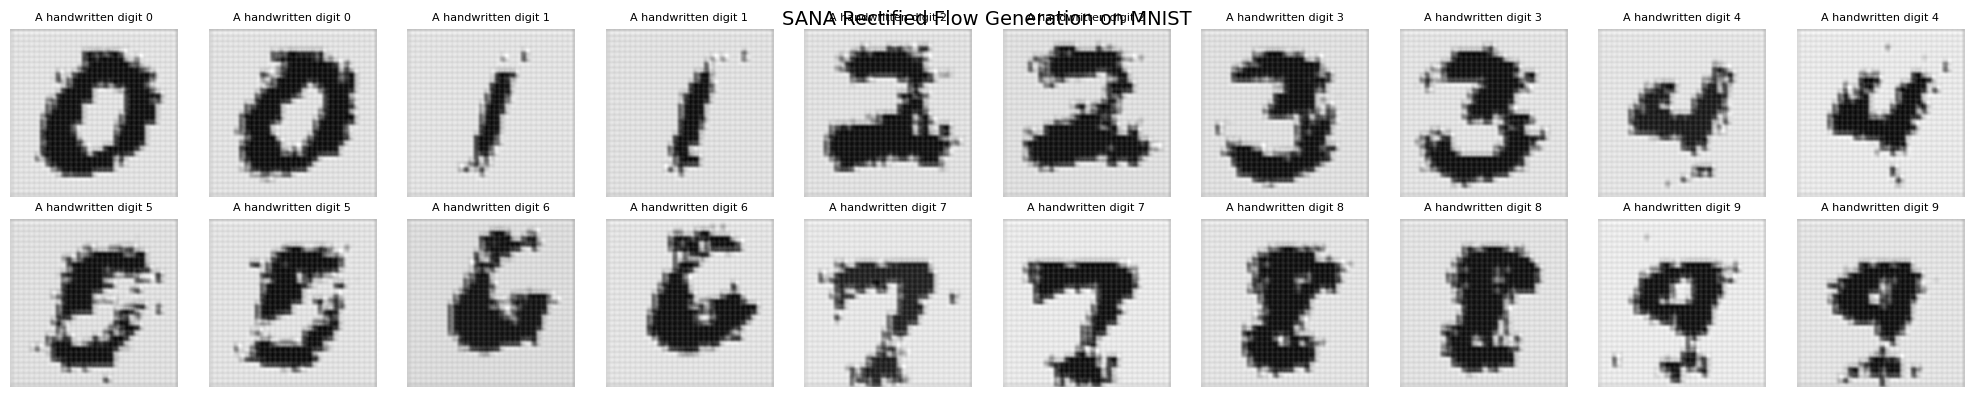

In [21]:

prompts = []
for digit in range(10):
    prompts.extend([f'A handwritten digit {digit}'] * 2)

print(prompts[:5], '...')

samples = sample_sana(sana, prompts, num_steps=30, guidance=4.5)

def plot_grid(images, titles=None):
    images = images.cpu().numpy()
    fig, axes = plt.subplots(2, 10, figsize=(20,4))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx,0], cmap='gray')
        ax.axis('off')
        if titles:
            ax.set_title(titles[idx], fontsize=8)
    plt.tight_layout()
    return fig

plot_grid(samples, prompts)
plt.suptitle('SANA Rectified Flow Generation on MNIST', fontsize=14)
plt.savefig('../outputs/sana_flow_mnist_true.png', dpi=150, bbox_inches='tight')
plt.show()
